# **Tópicos Selectos en Aprendizaje Maquinal**

**Doctorado en Ingeniería: mención en Señales, Sistemas e Inteligencia Computacional**

**FICH - UNL -** **Instituto de investigación en Señales, Sistemas e Inteligencia Computacional**

<img src=http://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png width="150">


Consultas: *Leandro Vignolo*
ldvignolo@sinc.unl.edu.ar

## **Trabajo práctico Nº 2: problemas de clasificación con datos reales**

**Modificar los parámetros correspondientes a cada método de clasificación y de validación cruzada, según se indica en la guía de TP disponible en http://tsam-fich.wikidot.com/apuntes**

**Para una referencia de los métodos y sus parámetros ver la documentación de sklearn en https://scikit-learn.org/**


---


***Guardar una copia personal de la Colab para trabajar en ella y guardar los cambios***


---




### **Carga de librerías**

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from warnings import simplefilter
import time
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# instalar librería adicional para el método Relief
!pip install sklearn-relief
import sklearn_relief as relief

# Para una referencia detallada de los métodos empleados y los parámetros correspondientes ver la documentación de sklearn en https://scikit-learn.org/stable/index.html


### **Definiciones de clasificadores**
***Modificar los parámetros de cada método***


Naive Bayes

In [2]:
# 1 Naive Bayes
def clf_NB(X_train, X_test, y_train, y_test):

    classes = np.unique(y_train)
    nt = y_train.shape[0]
    props = []
    for i in range(0,len(classes)):
        props.append( np.sum(y_train==classes[i])/nt )

    bayes = GaussianNB(priors=props, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Perceptrón Multicapa

In [3]:
# 2 MLP
def clf_MLP(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes = (5, 3),      # arquitectura de la red
                        activation = 'relu',              # función de activación
                        solver = 'adam',                  # algoritmo de optimización
                        learning_rate_init = 0.001,       # tasa de aprendizaje
                        max_iter = 300,                   # épocas de entrenamiento
                        tol = 0.0000001,                  # tolerancia de error
                        verbose = False)                  # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Red Nuronal con Funciones de Base Radial

In [4]:
# 3 RBF
def clf_RBF(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Árbol de Decisión

In [5]:
## 4 Árbol de decisión
def clf_TREE(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Random Forest

In [6]:
## 5 RandomForest
def clf_RF(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Máquina de Soporte Vectorial

In [7]:
from sklearn.svm import SVC # Import the SVC class

## 7 FEATURE SELECTION + SVM
def clf_FS_SVM(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=2)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    # Use SVC directly here instead of svm.SVC:
    clf = SVC(kernel='rbf', gamma=1) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

Método de Selección de Características y Máquina de Soporte Vectorial

In [8]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=2)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=1) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

Autoencoder y Máquina de Soporte Vectorial

In [9]:
## 8 Autoencoder + SVM

def clf_AE_SVM(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

k-Medias

In [10]:
## 9 k-means
def clf_kMeans(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

### **Ejercicio 1: dataset "Diabetes"**


Ambas funciones implementan el clasificador Naive Bayes de forma muy similar, con la única diferencia en el parámetro **var_smoothing**. Este parámetro se utiliza para evitar que alguna varianza calculada sea cero (lo que produciría divisiones por cero en el modelo gaussiano) y se define como una fracción (relativa a la varianza de cada característica) que se añade a cada varianza calculada. En el primer caso se utiliza 1e-09 y en el segundo 1e-05.

- **var_smoothing=1e-09:** Suavizado muy pequeño; puede ser adecuado si las varianzas de los datos son suficientemente grandes y estables.
- **var_smoothing=1e-05:** Suavizado mayor, que puede ayudar a estabilizar el modelo cuando hay características con varianzas extremadamente bajas.

In [11]:
def clf_NB_conf1(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-09)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_NB_conf2(X_train, X_test, y_train, y_test):
    bayes = GaussianNB(priors=None, var_smoothing=1e-05)
    # entrenamiento
    bayes.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = bayes.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Ambas funciones implementan un clasificador de red neuronal (MLP) pero con arquitecturas y parámetros de entrenamiento distintos. A continuación se detalla la diferencia:

- **clf_MLP1:**  
  - Arquitectura de red: dos capas ocultas con 8 y 4 neuronas, respectivamente.  
  - Función de activación: **relu**, lo que favorece una convergencia rápida y evita el problema de saturación en muchas ocasiones.  
  - Solucionador: **adam**, un optimizador robusto que adapta la tasa de aprendizaje de forma automática.  
  - Tasa de aprendizaje inicial: 0.001  
  - Máximo de iteraciones: 300  

- **clf_MLP2:**  
  - Arquitectura de red: dos capas ocultas con 16 neuronas cada una, lo que implica una red más profunda o con mayor capacidad.  
  - Función de activación: **tanh**, que produce salidas en el rango [-1,1] y puede ser más sensible a la centralización de los datos.  
  - Solucionador: **sgd** (descenso del gradiente estocástico), el cual es más sensible a la elección de la tasa de aprendizaje y puede requerir más iteraciones para converger.  
  - Tasa de aprendizaje inicial: 0.01  
  - Máximo de iteraciones: 500  

Una arquitectura más pequeña (8,4) con **relu** y **adam** suele converger más rápido y es menos propensa a quedar atrapada en mínimos locales, mientras que una arquitectura más grande (16,16) con **tanh** y **sgd** puede captar relaciones más complejas, pero además puede requerir un mayor ajuste de parámetros (como la tasa de aprendizaje) y más iteraciones para alcanzar la convergencia.

In [12]:
def clf_MLP1(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(8,4),
                         activation='relu',
                         solver='adam',
                         learning_rate_init=0.001,
                         max_iter=300)               # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

def clf_MLP2(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(16,16),
                         activation='tanh',
                         solver='sgd',
                         learning_rate_init=0.01,
                         max_iter=500)              # mostrar salida durante entrenamiento
    # entrenamiento
    clf.fit(X_train, y_train)
    # predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Ambas funciones implementan un clasificador basado en una red con capa oculta RBF de forma similar, diferenciándose únicamente en el número de centros (o "clusters") que se utilizan para la transformación:

- **clf_RBF1:**  
  - Utiliza **8 clusters** en el algoritmo KMeans.  
  - Esto genera una nueva representación ($Z_{train}$ y $Z_{test}$) de dimensión (n_muestras, 8), en la que cada "feature" es el valor de la función RBF calculado con respecto a uno de los 8 centros.

- **clf_RBF2:**  
  - Utiliza **16 clusters** en KMeans, por lo que la salida tendrá dimensión (n_muestras, 16).  
  - Con más centros se captura potencialmente más detalle de la distribución de los datos, pero también se incrementa la dimensión del espacio mapeado.

In [13]:
# 3 RBF
def clf_RBF1(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=8)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


# 3 RBF
def clf_RBF2(X_train, X_test, y_train, y_test):

    # entreno centroides con Kmeans usando datos de train
    model = KMeans(n_clusters=16)                 # definir cantidad de centroides
    model.fit(X_train)

    sigma = np.ones(model.n_clusters)
    Z_train = np.empty([X_train.shape[0],model.n_clusters])
    Z_test  = np.empty([X_test.shape[0],model.n_clusters])
    # calculo salidas de la capa RBF (mapeo)
    for clus in range(0,model.n_clusters):
        # estimación de la STD media para cada clúster/centroide sobre datos de entrenamiento
        aux = X_train[model.labels_==clus]
        if len(aux)!=0:                                # si el centroide no quedó sin patrones
            sigma[clus] = np.mean(np.std(aux,axis=0))  # STD promedio sobre las dimensiones
        if (sigma[clus]==0):
            sigma[clus] = 1.0
        # obtengo la salida de cada RBF con datos de train y test
        # las salidas las RBF son las nuevas features y las guardo en las columnas de los array para train y test
        Z_train[:,clus] = rbf_kernel([model.cluster_centers_[clus]], X_train, gamma=1.0/(sigma[clus]**2)).reshape(X_train.shape[0])
        Z_test[:,clus]  = rbf_kernel([model.cluster_centers_[clus]], X_test,  gamma=1.0/(sigma[clus]**2)).reshape(X_test.shape[0])

    # defino y entreno la capa de salida
    clf = Perceptron(tol=1e-3, random_state=0)   # definir tolerancia de error
    clf.fit(Z_train, y_train)
    # obtengo las predicciones de la capa de salida para los datos de prueba
    y_pred = clf.predict(Z_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

Ambas funciones implementan un árbol de decisión, pero difieren en la forma en que se configuran los hiperparámetros:

- **clf_TREE1:**  
  - **max_depth=2:** El árbol se limita a una profundidad de 2, lo que genera un modelo muy simple (alto sesgo, baja varianza). **criterion='gini':** Se utiliza el índice de Gini para medir la impureza en las particiones.  
  - Se fija un random_state para asegurar la reproducibilidad.

- **clf_TREE2:**  
  - **max_depth=None:** No se impone una profundidad máxima, permitiendo que el árbol crezca según los datos. **criterion='entropy':** Se utiliza la entropía (o ganancia de información) como medida de impureza.  
  - Se agregan restricciones adicionales:  
    - **min_samples_split=5:** Se requiere que al menos 5 muestras estén presentes para poder dividir un nodo.  
    - **min_samples_leaf=2:** Cada hoja debe tener al menos 2 muestras, lo que puede ayudar a reducir el sobreajuste.  

Estas diferencias inciden en el compromiso entre sesgo y varianza. Mientras que el primer árbol es muy sencillo y, por tanto, puede no captar la complejidad de los datos (alto sesgo), el segundo permite modelos más complejos (posible menor sesgo), pero incluye restricciones para evitar el sobreajuste.

In [14]:
## 4 Árbol de decisión
def clf_TREE1(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(random_state=0, max_depth=2, criterion='gini') # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 4 Árbol de decisión
def clf_TREE2(X_train, X_test, y_train, y_test):
    dtree = DecisionTreeClassifier(max_depth=None, criterion='entropy',
                                min_samples_split=5, min_samples_leaf=2) # definición y seteo de parámetros del clasificador
    # entrenamiento
    dtree.fit(X_train, y_train)
    # prueba
    y_pred = dtree.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

**clf_RF1:**  
- **max_depth=None:** No se impone un límite en la profundidad de cada árbol, lo que permite que los árboles crezcan hasta la máxima extensión posible. Esto puede capturar complejidades en los datos, pero también aumenta el riesgo de sobreajuste, especialmente en conjuntos de datos pequeños. **n_estimators=100:** Se construyen 100 árboles.  
- **Criterio:** Al no especificarse, se utiliza el criterio por defecto ("gini").

**clf_RF2:**  
- **max_depth=5:** Se limita la profundidad de cada árbol a 5 niveles. Esto ayuda a evitar el sobreajuste, ya que cada árbol es menos complejo, pero podría provocar un subajuste si la complejidad del problema lo requiere. **criterion='entropy':** Se utiliza la entropía (o ganancia de información) para decidir las divisiones, lo cual puede producir diferencias sutiles en comparación con el índice de Gini.  
- **n_estimators=300:** Se construyen 300 árboles, lo que puede aumentar la robustez del modelo y reducir la varianza en las predicciones.  

Con **clf_RF1** se obtiene un modelo potencialmente más complejo (árboles muy profundos), lo que puede resultar en mayor capacidad para captar relaciones complejas, pero a costa de un riesgo mayor de sobreajuste. Y con **clf_RF2** se controla la complejidad de cada árbol (máxima profundidad de 5) y se compensa aumentando el número de árboles a 300, lo que generalmente mejora la estabilidad del modelo y puede resultar en mejor generalización, especialmente si se dispone de pocos datos.

In [15]:
## 5 RandomForest
def clf_RF1(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 5 RandomForest
def clf_RF2(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=5, criterion='entropy', random_state=0, n_estimators=300) # parámetros del clasificador RandomForest
    # entrenamiento
    clf.fit(X_train, y_train)
    # prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf



- **clf_SVM1:**  
  - Se crea el clasificador SVM con un **kernel polinomial**. Esto significa que el kernel realiza una transformación polinomial de grado 2. Y el parámetro **coef0=1** actúa como término independiente en el cálculo del kernel, y **gamma='auto'** hace que el coeficiente gamma se establezca automáticamente en función del número de características (es decir, 1/n_features).  
  - Esta configuración puede capturar relaciones polinomiales entre las características.

- **clf_SVM2:**  
  - Se crea el clasificador SVM con un **kernel RBF (función base radial)** , que mapea los datos a un espacio de dimensión infinita, permitiendo capturar relaciones no lineales complejas. Y el parámetro **gamma=0.01** controla la influencia de cada muestra (un gamma más bajo hace que la influencia se extienda a una región más amplia), y **C=10** establece el parámetro de regularización, penalizando de forma más fuerte los errores de clasificación.

In [16]:
## 6 SVM
def clf_SVM1(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

## 6 SVM
def clf_SVM2(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    #clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    clf = svm.SVC(kernel='rbf',gamma=0.01, C=10)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf



- **clf_FS_SVM1:**  
  - Se seleccionan **3 características** (k=3) con SelectKBest. El clasificador SVM se define con un kernel **lineal** y C=1.0. Este enfoque puede ser útil cuando se desea un modelo simple, interpretativo y lineal que trabaje con un número muy reducido de variables.

- **clf_FS_SVM2:**  
  - Se seleccionan **5 características** (k=5) con SelectKBest, lo que permite captar más información potencialmente relevante. Se utiliza un kernel **RBF** con gamma=0.1 y C=10, lo que implica un modelo no lineal con mayor capacidad de adaptación a relaciones complejas en los datos. La configuración con kernel RBF y un valor mayor de C generalmente permite una mayor flexibilidad, pero también puede aumentar el riesgo de sobreajuste si no se ajusta adecuadamente.

In [17]:
## 7 FEATURE SELECTION + SVM
def clf_FS_SVM1(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=3)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='linear', C=1.0) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf

## 7 FEATURE SELECTION + SVM
def clf_FS_SVM2(X_train, X_test, y_train, y_test):

    # defino el método de ranking con criterio de ANOVA F (f_classif)
    FS = SelectKBest(f_classif, k=5)        # definir cuántas características se desean seleccionar
    # realizo la selección en base a datos de train
    FS = FS.fit(X_train, y_train)
    # mapeo / aplico la selección en train y test
    X_train_new = FS.transform(X_train)
    X_test_new  = FS.transform(X_test)
    # defino clasificador SVM
    clf = svm.SVC(kernel='rbf', gamma=0.1, C=10) # Kernel RBF
    # entreno el clasificador
    clf.fit(X_train_new, y_train)
    # predicción en datos de prueba
    y_pred = clf.predict(X_test_new)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train_new.shape[1]
    return acc, uar, rec, nf



- **Arquitectura de la representación latente:**  
  - En **clf_AE_SVM1**, la capa latente tiene **2 neuronas** (n_latent = 2), lo que reduce la dimensionalidad a 2 y se utiliza la activación **tanh** en todo el autoencoder. Esto puede facilitar la visualización y, en ciertos casos, capturar relaciones no lineales de forma simétrica (ya que tanh produce salidas en el rango [-1, 1]).  
  - En **clf_AE_SVM2**, la capa latente es de **5 neuronas** (n_latent = 5) y se utiliza la activación **relu**. Esto permite una representación con mayor capacidad (más dimensiones), pero puede producir salidas asimétricas y requiere que los datos estén bien escalados, ya que relu no es simétrica.

Con **2 dimensiones** (tanh) se obtiene una proyección muy compacta, adecuada para visualización, pero puede perder cierta información discriminante. Y con **5 dimensiones** (relu) se retiene mayor complejidad, lo que podría traducirse en mejores resultados predictivos en problemas donde la separación de clases requiere más información, aunque la visualización directa se vuelva menos intuitiva.

In [18]:
## 8 Autoencoder + SVM

def clf_AE_SVM1(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 2
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'tanh',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf


## 8 Autoencoder + SVM

def clf_AE_SVM2(X_train, X_test, y_train, y_test, plot=False, ax1=None, ax2=None):


    n_input = len(X_train[0])
    # Estructura del codificador
    n_encoder1 = 500
    n_encoder2 = 300
    n_latent = 5
    # Estructura del decodificador
    n_decoder2 = 300
    n_decoder1 = 500
    # definición del Autoencoder
    AE = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                      activation = 'relu',
                      solver = 'adam',
                      learning_rate_init = 0.0001,
                      max_iter = 300,
                      tol = 0.0000001,
                      verbose = False)

    # Entrenamiento del autoencoder
    AE.fit(X_train, X_train)

    # defino función para obtener representación latente
    def encoder(data):
        data = np.asmatrix(data)
        encoder1 = data*AE.coefs_[0] + AE.intercepts_[0]
        encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
        encoder2 = encoder1*AE.coefs_[1] + AE.intercepts_[1]
        encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
        latent = encoder2*AE.coefs_[2] + AE.intercepts_[2]
        latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
        return np.asarray(latent)

    # mapeo train / test
    train_latent = encoder(X_train)
    test_latent = encoder(X_test)

    if plot:
        ax1.scatter(train_latent[:,0], train_latent[:,1], s=50, c=y_train, marker="o")
        ax1.set_xlabel("Latent1")
        ax1.set_ylabel("Latent2")
        ax1.set_title("Train Data")
        ax2.scatter(test_latent[:,0],  test_latent[:,1],  s=50, c=y_test, marker="o")
        ax2.set_xlabel("Latent1")
        ax2.set_ylabel("Latent2")
        ax2.set_title("Test Data")

    # entrenamiento de un SVM empleando la representación latente
    #clf = svm.SVC(kernel='linear') # SVM Kernel lineal
    clf = svm.SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1) # SVM Kernel RBF
    clf.fit(train_latent, y_train)
    y_pred = clf.predict(test_latent)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = train_latent.shape[1]
    return acc, uar, rec, nf

**clf_kMeans1:** Utiliza 8 clusters, esto implica que el espacio de datos se particiona en 8 regiones, lo que puede capturar más matices en la distribución de los datos, pero a la vez aumenta la complejidad del mapeo. Y **clf_kMeans2:** solo utiliza 4 clusters, la partición es más simple y puede ser más robusta en escenarios con menos muestras o cuando se busca un modelo más generalizado.

In [19]:
## 9 k-means
def clf_kMeans1(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=8)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf


## 9 k-means
def clf_kMeans2(X_train, X_test, y_train, y_test):
    # entreno el algoritmo de clustering
    model = KMeans(n_clusters=4)
    model.fit(X_train)

    # defino vector para asignar las etiquetas a los datos de entrenamiento
    train_Labels = np.empty(len(X_train))
    # defino vector para asignar una etiqueta de clase a cada clúster
    cluster_labels = np.empty(model.n_clusters)
    # para cada clúster
    for clus in range(0,model.n_clusters):
        # model.labels_ indica el clúster al que pertenece cada patrón
        original_labels = y_train[model.labels_==clus]
        # original_labels contiene las etiquetas de los elementos del clúster
        count = Counter(original_labels)
        # asigno etiqueta de clase a cada clúster
        cluster_labels[clus] = max(count, key=count.get)
        # asigno etiqueta de clase a cada patrón de train en ese clúster
        train_Labels[model.labels_==clus] = cluster_labels[clus]

    # obtengo un clúster para cada dato de test
    clus_test_pred = model.predict(X_test)
    # obtengo etiqueta para cada dato de test
    y_pred = cluster_labels[clus_test_pred]
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    nf = X_train.shape[1]
    return acc, uar, rec, nf

In [20]:
# defino lista de clasificadores
classifiers = ["clf_NB_conf1","clf_NB_conf2","clf_MLP1","clf_MLP2","clf_RBF1","clf_RBF2","clf_TREE1","clf_TREE2","clf_RF1","clf_RF2","clf_SVM1","clf_SVM2","clf_FS_SVM1","clf_FS_SVM2","clf_AE_SVM1","clf_AE_SVM2","clf_kMeans1","clf_kMeans2"]

# carga de datos
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', header=None)
# separo patrones en X y etiquetas en Y
X = np.array(data)[:,0:8]
Y = np.array(data)[:,8]
# aleatorización de los datos
X, Y = shuffle(X, Y, random_state=0)

**Validación cruzada: particionado simple train/test**


Para test_size = 0.3

In [21]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7273 │ 0.6849 │ 0.5432 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7619 │ 0.7258 │ 0.6049 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7576 │ 0.7338 │ 0.6543 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.5974 │ 0.6673 │ 0.9012 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6494 │ 0.5000 │ 0.0000 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

Para test_size = 0.2

In [22]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vrec = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                      Simple CV                       :::')
table = [["Clasificador","ACC", "UAR", "Recall", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%.4f' % vrec[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

:::                      Simple CV                       :::
╒════╤══════════════╤════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ Recall │ # Features │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.7338 │ 0.6885 │ 0.5370 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7792 │ 0.7363 │ 0.5926 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.7597 │ 0.7128 │ 0.5556 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.6429 │ 0.6356 │ 0.6111 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.6494 │ 0.5000 │ 0.0000 │    8.0     │
├────┼──────────────┼────────┼────────┼────────┼────────────┤
│  7 │   

**K-Fold Cross Validation**


::: Resultados de k-Fold CV con n_splits = 4 :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤═════════════╤════════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ Recall Mean │ Recall STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  1 │   NB_conf1   │  0.7604  │ 0.0143  │  0.7271  │ 0.0086  │   0.6189    │   0.0206   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  2 │   NB_conf2   │  0.7604  │ 0.0143  │  0.7271  │ 0.0086  │   0.6189    │   0.0206   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  3 │     MLP1     │  0.7604  │ 0.0308  │  0.7170  │ 0.0193  │   0.5754    │   0.0209   │    8.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼─────────────┼────────────┼────────────┤
│  4 │     MLP

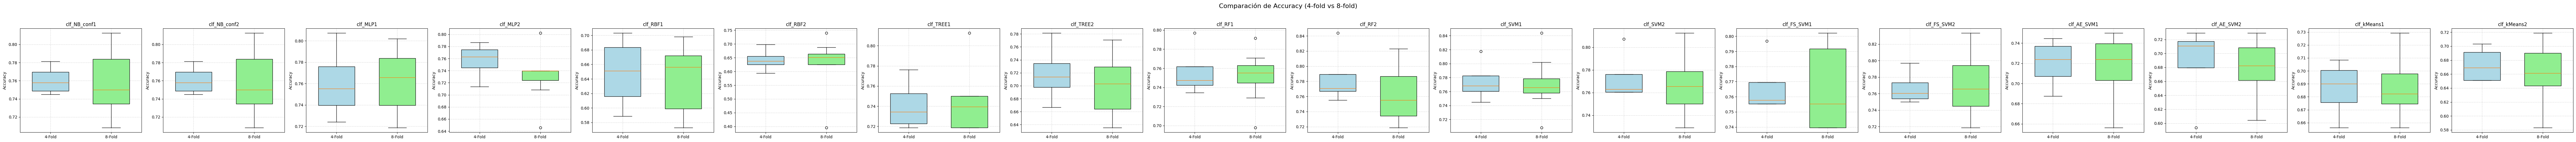

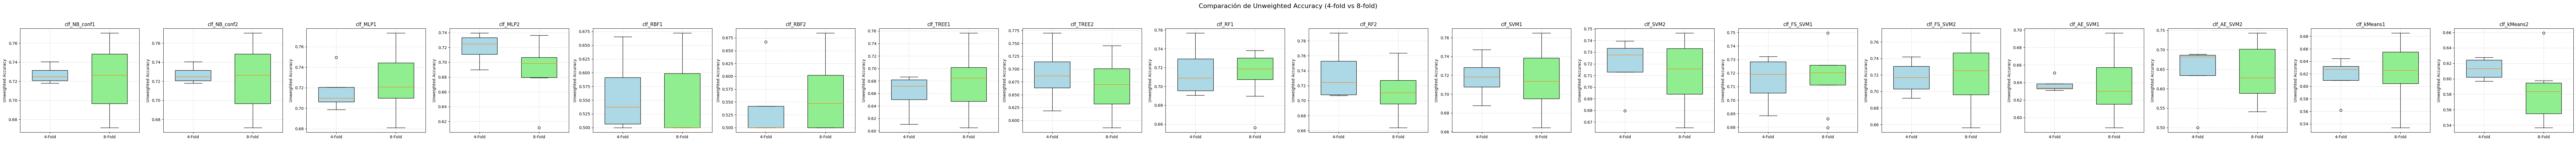

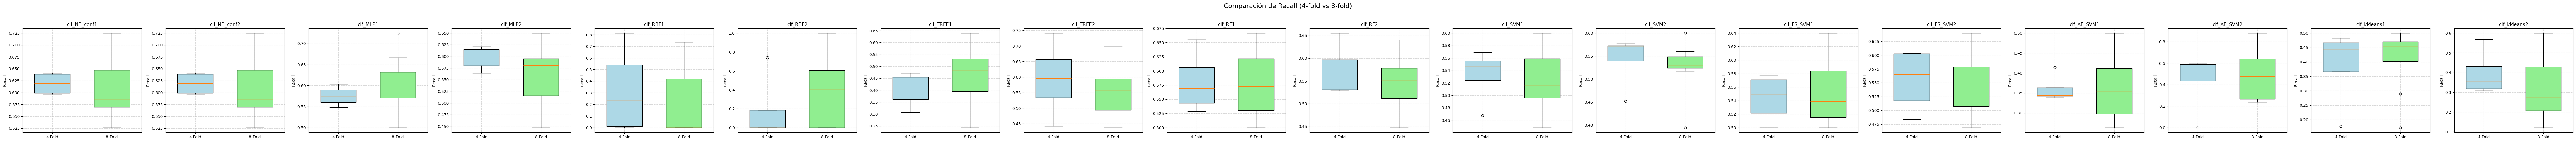

In [23]:
import numpy as np
from sklearn.model_selection import KFold  # o StratifiedKFold si se prefiere
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tabulate import tabulate

# Lista con los números de folds que se desea evaluar
fold_values = [4, 8]

# Diccionario para almacenar los resultados para cada validación (kfold)
results = {}

# Itero sobre cada número de folds (4 y 8)
for NFfolds in fold_values:
    # Inicializo estructuras para cada métrica y para cada clasificador
    Macc = [[] for _ in range(len(classifiers))]
    Muar = [[] for _ in range(len(classifiers))]
    Mrec = [[] for _ in range(len(classifiers))]
    Mnf  = [[] for _ in range(len(classifiers))]

    # Creo el objeto KFold (puede añadirse shuffle si se desea)
    kf = KFold(n_splits=NFfolds, shuffle=True, random_state=42)
    # Si se desea utilizar KFold estratificado, descomente la siguiente línea:
    # kf = StratifiedKFold(n_splits=NFfolds, shuffle=True, random_state=42)

    # Realizo la validación cruzada
    for train_index, test_index in kf.split(X):
        # Asigno datos y etiquetas según los índices del fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # Estandarización de los datos (sobre cada fold)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test  = scaler.transform(X_test)

        # Llamada a cada clasificador con el fold actual
        for i, clf_name in enumerate(classifiers):
            # Se asume que cada función clasificador está definida en el ámbito local
            acc, uar, rec, nf = locals()[clf_name](X_train, X_test, y_train, y_test)
            Macc[i].append(acc)
            Muar[i].append(uar)
            Mrec[i].append(rec)
            Mnf[i].append(nf)

    # Convierto las listas a arrays para facilitar el cálculo de estadísticas
    Macc = np.array(Macc)
    Muar = np.array(Muar)
    Mrec = np.array(Mrec)
    Mnf  = np.array(Mnf)

    # Calculo las estadísticas: media y desviación estándar
    stats = {
        'acc_mean': np.mean(Macc, axis=1),
        'uar_mean': np.mean(Muar, axis=1),
        'rec_mean': np.mean(Mrec, axis=1),
        'nf_mean':  np.mean(Mnf, axis=1),
        'acc_std':  np.std(Macc, axis=1),
        'uar_std':  np.std(Muar, axis=1),
        'rec_std':  np.std(Mrec, axis=1)
    }

    # Guardo los resultados para el número de folds actual
    results[NFfolds] = {
        'Macc': Macc,
        'Muar': Muar,
        'Mrec': Mrec,
        'Mnf':  Mnf,
        'stats': stats
    }

    # Imprimo una tabla con los resultados para la validación con NFfolds
    print(f"\n::: Resultados de k-Fold CV con n_splits = {NFfolds} :::")
    table = [["Clasificador", "ACC Mean", "ACC STD", "UAR Mean", "UAR STD", "Recall Mean", "Recall STD", "# Features"]]
    for i, clf_name in enumerate(classifiers):
        table.append([
            clf_name[4:],  # Se asume que se quitan los 4 primeros caracteres (por ejemplo, 'clf')
            f"{stats['acc_mean'][i]:.4f}",
            f"{stats['acc_std'][i]:.4f}",
            f"{stats['uar_mean'][i]:.4f}",
            f"{stats['uar_std'][i]:.4f}",
            f"{stats['rec_mean'][i]:.4f}",
            f"{stats['rec_std'][i]:.4f}",
            f"{stats['nf_mean'][i]:.1f}"
        ])
    print(tabulate(table, tablefmt="fancy_grid", showindex="always", stralign="center"))

# ---------------------------------------------------------------------
# Generación de BoxPlots para cada métrica (accuracy, unweighted accuracy y recall)
# Cada figura tendrá un subplot por clasificador, comparando 4-fold vs 8-fold.
# ---------------------------------------------------------------------

# Lista de métricas a graficar: cada entrada es (nombre, etiqueta eje y)
metric_list = [
    ('Macc', 'Accuracy'),
    ('Muar', 'Unweighted Accuracy'),
    ('Mrec', 'Recall')
]

for metric_key, metric_label in metric_list:
    num_classifiers = len(classifiers)
    # Crear figura y ejes (una fila con un subplot por clasificador)
    fig, axes = plt.subplots(1, num_classifiers, figsize=(5*num_classifiers, 5), squeeze=False)
    fig.suptitle(f'Comparación de {metric_label} (4-fold vs 8-fold)', fontsize=16)

    for i, clf_name in enumerate(classifiers):
        # Extraigo los valores de la métrica para el clasificador i para ambos métodos de validación
        values_4fold = results[4][metric_key][i]  # Array con NFfolds=4
        values_8fold = results[8][metric_key][i]  # Array con NFfolds=8

        # Preparar los datos para boxplot: una lista con dos elementos
        data_to_plot = [values_4fold, values_8fold]

        # Boxplot en el subplot correspondiente
        ax = axes[0, i]
        bp = ax.boxplot(data_to_plot, patch_artist=True, widths=0.6)

        # Personalización de colores
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_title(clf_name)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['4-Fold', '8-Fold'])
        ax.set_ylabel(metric_label)
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ---------------------------------------------------------------------
# Análisis (comentario):
#
# - Al comparar los BoxPlots para cada métrica se puede observar si existe
#   alguna diferencia en la distribución de los valores obtenidos al utilizar 4 o 8 folds.
# - Una mayor cantidad de folds (8-fold) implica que cada fold es más pequeño, lo que
#   puede derivar en una mayor variabilidad de las métricas; sin embargo, también puede
#   proporcionar una estimación más robusta al aprovechar más particiones.
# - Se recomienda analizar, para cada clasificador, si las medias y las dispersión (medida
#   por la desviación estándar) son consistentes entre ambos métodos de validación.
#
# Con base en el análisis gráfico y en los valores tabulados se podrá concluir cuál método
# resulta más adecuado para el conjunto de datos y los clasificadores considerados.
# ---------------------------------------------------------------------


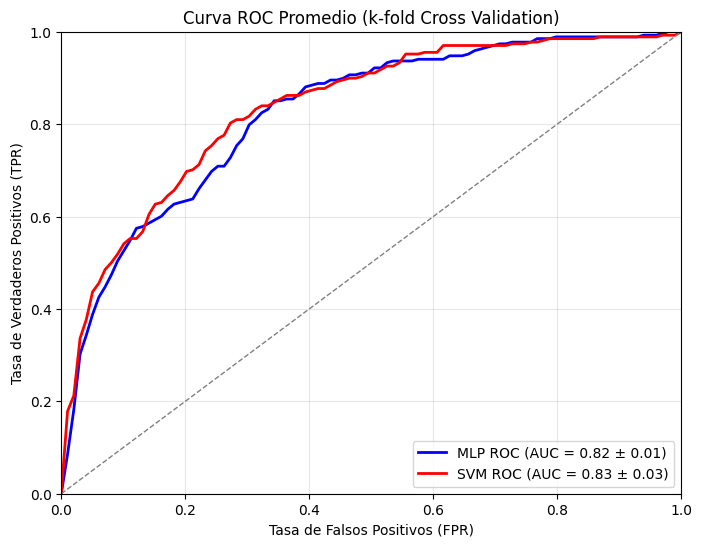

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Asumimos que ya se tienen definidos X (datos) e y (etiquetas binaras, 0 y 1)
# X, y = ... (ejemplo: X = np.array(...), y = np.array(...))

# Parámetros para la validación cruzada
n_splits = 5  # Número de folds para k-fold
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Arrays para almacenar las curvas ROC y AUC de cada fold para cada clasificador
tprs_mlp = []
aucs_mlp = []
tprs_svm = []
aucs_svm = []
# Definimos un eje de FPR fijo para interpolar (por ejemplo, 100 puntos entre 0 y 1)
mean_fpr = np.linspace(0, 1, 100)

# Bucle sobre cada fold
for train_idx, test_idx in cv.split(X, Y):
    # División de datos en entrenamiento y test
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Estandarización (importante para ambos clasificadores)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # -----------------------
    # Entrenamiento y evaluación del MLP
    # -----------------------
    mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                        max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)

    # Obtención de las probabilidades para la clase positiva (índice 1)
    y_score_mlp = mlp.predict_proba(X_test)[:, 1]

    # Cálculo de la curva ROC para el MLP
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_score_mlp)
    roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
    aucs_mlp.append(roc_auc_mlp)

    # Interpolación del TPR a los puntos definidos en mean_fpr
    tpr_interp_mlp = np.interp(mean_fpr, fpr_mlp, tpr_mlp)
    tpr_interp_mlp[0] = 0.0  # Aseguramos que comience en 0
    tprs_mlp.append(tpr_interp_mlp)

    # -----------------------
    # Entrenamiento y evaluación del SVM
    # -----------------------
    # Usamos SVM lineal para obtener la función de decisión
    svm_aux = SVC(kernel='linear', probability=False, random_state=42)
    svm_aux.fit(X_train, y_train)

    # Obtenemos los scores de la función de decisión
    y_score_svm = svm_aux.decision_function(X_test)

    # Cálculo de la curva ROC para el SVM
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs_svm.append(roc_auc_svm)

    # Interpolación del TPR para el SVM
    tpr_interp_svm = np.interp(mean_fpr, fpr_svm, tpr_svm)
    tpr_interp_svm[0] = 0.0
    tprs_svm.append(tpr_interp_svm)

# Promedio de las curvas ROC y AUC para el MLP
mean_tpr_mlp = np.mean(tprs_mlp, axis=0)
mean_tpr_mlp[-1] = 1.0
mean_auc_mlp = auc(mean_fpr, mean_tpr_mlp)
std_auc_mlp = np.std(aucs_mlp)

# Promedio de las curvas ROC y AUC para el SVM
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr_svm)
std_auc_svm = np.std(aucs_svm)

# Graficamos la curva ROC promedio para ambos clasificadores
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr_mlp, color='blue', lw=2,
         label=f'MLP ROC (AUC = {mean_auc_mlp:.2f} ± {std_auc_mlp:.2f})')
plt.plot(mean_fpr, mean_tpr_svm, color='red', lw=2,
         label=f'SVM ROC (AUC = {mean_auc_svm:.2f} ± {std_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Promedio (k-fold Cross Validation)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# ---------------------------------------------------------------------
# Interpretación:
# - Se observa la comparación de las curvas ROC promedio de MLP y SVM.
# - El AUC (area bajo la curva) junto con su desviación estándar se muestran en la leyenda.
# - Un AUC mayor indica mejor desempeño en la discriminación de clases.
# - Se puede analizar cuál de los dos clasificadores presenta un desempeño más robusto
#   según estas métricas.
# ---------------------------------------------------------------------


### **Ejercicio 2: dataset "Iris"**

In [25]:
# carga de datos
iris = load_iris()
# aleatorización
X, Y = shuffle(iris.data, iris.target, random_state=0)
# defino lista de clasificadores
#classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_FS_SVM","clf_AE_SVM","clf_kMeans"]

In [26]:
from sklearn.svm import SVC # Import the SVC class

## 6 SVM
def clf_SVM(X_train, X_test, y_train, y_test):
    #clf = svm.SVC(kernel='linear')                               # SVM Kernel Lineal
    clf = SVC(kernel='poly', degree=2, coef0=1, gamma='auto') # SVM Kernel polinomial
    #clf = svm.SVC(kernel='rbf',gamma=1)                          # SVM Kernel RBF
    # Entrenamiento
    clf.fit(X_train, y_train)
    # Predicción sobre datos de prueba
    y_pred = clf.predict(X_test)
    # métricas
    acc = accuracy_score(y_test, y_pred)
    uar = balanced_accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average=None)[1]
    # This line assumes you want recall for class 1; adjust if needed
    nf = X_train.shape[1]
    return acc, uar, rec, nf

**Validación cruzada: particionado simple train/test**

In [27]:
# validación cruzada: partición train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
vacc = []
vuar = []
vnf  = []
# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(


:::                  Simple CV                  :::
╒════╤══════════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ # Features │
├────┼──────────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.9556 │ 0.9556 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.9556 │ 0.9556 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7556 │ 0.7556 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.9778 │ 0.9778 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.5111 │ 0.5111 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.3333 │ 0.3333 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  7 │    TREE1     │ 0.9556 │ 0.9556 │    4.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  8 │    TREE2     │ 0.9556 │ 0.9556 │    4.0 

**K-Fold Cross Validation**

In [28]:
NFfolds = 4   # >=2

# inicializo estructuras para guardar resultados
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

# Validación cruzada K-Fold (estratificada / no estratificada)

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# conversión a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# estadísticas de desempeño
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

# imprimo una tabla con los resultados
print(':::                            k-Ffold CV                               :::')
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf]])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=4. All the features will be returned.
  warnings.warn(


:::                            k-Ffold CV                               :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  1 │   NB_conf1   │  0.9667  │ 0.0344  │  0.9705  │ 0.0300  │    4.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  2 │   NB_conf2   │  0.9667  │ 0.0344  │  0.9705  │ 0.0300  │    4.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  3 │     MLP1     │  0.7948  │ 0.1408  │  0.7502  │ 0.1743  │    4.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  4 │     MLP2     │  0.9467  │ 0.0267  │  0.9470  │ 0.0213  │    4.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  5 │     RBF1     │  0.8611  │ 0.1069  │  0.8650  │ 0.0936  │    4.0     │


***Repetimos empleando las dos primeras componentes principales***

**Validación cruzada: particionado simple train/test**

In [29]:
# validación cruzada: partición train/test #

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Estandarización de los datos
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PCA: reducción dimensional
pca = PCA(n_components=2)
# Ajuste sobre de train
pca.fit(X_train)
# transformación de datos train y test
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

vacc = []
vuar = []
vnf  = []

# llamada a cada clasificador con el fold actual
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    # guardo las medidas de desempeño en un vector
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

# imprimo una tabla con los resultados
print(':::                  Simple CV                  :::')
table = [["Clasificador","ACC", "UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([ classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], '%1.1f' % vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(


:::                  Simple CV                  :::
╒════╤══════════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ # Features │
├────┼──────────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.8667 │ 0.8667 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.8667 │ 0.8667 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.8444 │ 0.8444 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.9556 │ 0.9556 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.7778 │ 0.7778 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.8667 │ 0.8667 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  7 │    TREE1     │ 0.9333 │ 0.9333 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  8 │    TREE2     │ 0.9556 │ 0.9556 │    2.0 

**K-Fold Cross Validation**

In [30]:
## K-Folds Cross Validation ##

NFfolds = 5   # >=2
Macc = [[] for i in range(len(classifiers))]
Muar = [[] for i in range(len(classifiers))]
Mnf  = [[] for i in range(len(classifiers))]

kf = KFold(n_splits=NFfolds)                            # non Stratified KFold
# kf = StratifiedKFold(n_splits=NFfolds)                # Stratified KFold

for train_index, test_index in kf.split(X):

    # asigno datos y etiquetas segun los índices del fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Estandarización de los datos (sobre cada fold)
    scaler = StandardScaler()
    # Ajuste sobre de train
    scaler.fit(X_train)
    # transformación de datos train y test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA: reducción dimensional
    pca = PCA(n_components=2)
    # Ajuste sobre de train
    pca.fit(X_train)
    # transformación de datos train y test
    X_PC_train = pca.transform(X_train)
    X_PC_test = pca.transform(X_test)

    # llamada a cada clasificador con el fold actual
    for clf in range(0,len(classifiers)):
        acc, uar, _, nf = locals()[classifiers[clf]](X_PC_train, X_PC_test, y_train, y_test)
        # guardo las medidas de desempeño en un vector
        Macc[clf].append(acc)
        Muar[clf].append(uar)
        Mnf[clf].append(nf)

# convierto a array
Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)
# calculo estadísticas
acc_mean = np.mean(Macc,axis=1)
uar_mean = np.mean(Muar,axis=1)
nf_mean  = np.mean(Mnf,axis=1)
acc_std = np.std(Macc,axis=1)
uar_std = np.std(Muar,axis=1)

print(':::                            k-Ffold CV                               :::')
# imprimo una tabla con los resultados
table = [["Clasificador","ACC Mean","ACC STD","UAR Mean","UAR STD", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % acc_mean[clf], '%.4f' % acc_std[clf], '%.4f' % uar_mean[clf], '%.4f' % uar_std[clf], '%1.1f' % nf_mean[clf] ])
print(tabulate(table, tablefmt="fancy_grid", showindex="always",stralign="center"))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11

:::                            k-Ffold CV                               :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  1 │   NB_conf1   │  0.8933  │ 0.0389  │  0.8976  │ 0.0375  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  2 │   NB_conf2   │  0.8933  │ 0.0389  │  0.8976  │ 0.0375  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  3 │     MLP1     │  0.7933  │ 0.1541  │  0.8029  │ 0.1155  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  4 │     MLP2     │  0.9133  │ 0.0267  │  0.9205  │ 0.0268  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  5 │     RBF1     │  0.8067  │ 0.1323  │  0.8120  │ 0.0898  │    2.0     │


**Graficación de los datos proyectados**

In [31]:
# -------------------------------
# Simple CV with PCA (reduce to 2 components)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, Y, test_size=0.3,
                                                             random_state=0, stratify=Y)
scaler_p = StandardScaler()
scaler_p.fit(X_train_p)
X_train_std_p = scaler_p.transform(X_train_p)
X_test_std_p  = scaler_p.transform(X_test_p)
pca = PCA(n_components=2)
pca.fit(X_train_std_p)
X_train_pca = pca.transform(X_train_std_p)
X_test_pca  = pca.transform(X_test_std_p)

vacc_p = []; vuar_p = []; vnf_p = []
for clf_name in classifiers:
    acc, uar, rec, nf = locals()[clf_name](X_train_pca, X_test_pca, y_train_p, y_test_p)
    vacc_p.append(acc)
    vuar_p.append(uar)
    vnf_p.append(nf)

print('::: Simple CV with PCA :::')
table = [["Clasificador", "ACC", "UAR", "# Features"]]
for i, clf_name in enumerate(classifiers):
    table.append([clf_name[4:], f"{vacc_p[i]:.4f}", f"{vuar_p[i]:.4f}", f"{vnf_p[i]:.1f}"])
print(tabulate(table, tablefmt="fancy_grid", showindex="always", stralign="center"))

# -------------------------------
# K-Fold Cross Validation with PCA reduction
NFfolds = 5
Macc = [[] for _ in range(len(classifiers))]
Muar = [[] for _ in range(len(classifiers))]
Mnf  = [[] for _ in range(len(classifiers))]

kf = KFold(n_splits=NFfolds, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(X):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = Y[train_idx], Y[test_idx]

    scaler_fold = StandardScaler()
    scaler_fold.fit(X_train_fold)
    X_train_fold_std = scaler_fold.transform(X_train_fold)
    X_test_fold_std  = scaler_fold.transform(X_test_fold)

    pca_fold = PCA(n_components=2)
    pca_fold.fit(X_train_fold_std)
    X_train_fold_pca = pca_fold.transform(X_train_fold_std)
    X_test_fold_pca  = pca_fold.transform(X_test_fold_std)

    for i, clf_name in enumerate(classifiers):
        acc, uar, rec, nf = locals()[clf_name](X_train_fold_pca, X_test_fold_pca, y_train_fold, y_test_fold)
        Macc[i].append(acc)
        Muar[i].append(uar)
        Mnf[i].append(nf)

Macc = np.array(Macc)
Muar = np.array(Muar)
Mnf  = np.array(Mnf)

acc_mean = np.mean(Macc, axis=1)
uar_mean = np.mean(Muar, axis=1)
nf_mean  = np.mean(Mnf, axis=1)
acc_std  = np.std(Macc, axis=1)
uar_std  = np.std(Muar, axis=1)

print('::: K-Fold CV with PCA :::')
table = [["Clasificador", "ACC Mean", "ACC STD", "UAR Mean", "UAR STD", "# Features"]]
for i, clf_name in enumerate(classifiers):
    table.append([clf_name[4:], f"{acc_mean[i]:.4f}", f"{acc_std[i]:.4f}",
                  f"{uar_mean[i]:.4f}", f"{uar_std[i]:.4f}", f"{nf_mean[i]:.1f}"])
print(tabulate(table, tablefmt="fancy_grid", showindex="always", stralign="center"))

# Create a dictionary similar to stats_kfold (using K-Fold arrays)
stats_kfold = {
    "Macc": Macc,   # shape: (n_classifiers, NFfolds)
    "Muar": Muar,
    "Mnf": Mnf
}

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(


::: Simple CV with PCA :::
╒════╤══════════════╤════════╤════════╤════════════╕
│  0 │ Clasificador │  ACC   │  UAR   │ # Features │
├────┼──────────────┼────────┼────────┼────────────┤
│  1 │   NB_conf1   │ 0.8667 │ 0.8667 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  2 │   NB_conf2   │ 0.8667 │ 0.8667 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  3 │     MLP1     │ 0.7778 │ 0.7778 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  4 │     MLP2     │ 0.9556 │ 0.9556 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  5 │     RBF1     │ 0.7556 │ 0.7556 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  6 │     RBF2     │ 0.8222 │ 0.8222 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  7 │    TREE1     │ 0.9333 │ 0.9333 │    2.0     │
├────┼──────────────┼────────┼────────┼────────────┤
│  8 │    TREE2     │ 0.9556 │ 0.9556 │    2.0     │
├────┼─────────────

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=3 is greater than n_features=2. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11

::: K-Fold CV with PCA :::
╒════╤══════════════╤══════════╤═════════╤══════════╤═════════╤════════════╕
│  0 │ Clasificador │ ACC Mean │ ACC STD │ UAR Mean │ UAR STD │ # Features │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  1 │   NB_conf1   │  0.8933  │ 0.0249  │  0.8842  │ 0.0352  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  2 │   NB_conf2   │  0.8933  │ 0.0249  │  0.8842  │ 0.0352  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  3 │     MLP1     │  0.8000  │ 0.0966  │  0.7998  │ 0.0885  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  4 │     MLP2     │  0.9133  │ 0.0340  │  0.9121  │ 0.0422  │    2.0     │
├────┼──────────────┼──────────┼─────────┼──────────┼─────────┼────────────┤
│  5 │     RBF1     │  0.7200  │ 0.0909  │  0.7241  │ 0.1104  │    2.0     │
├────┼──────────────┼──────────┼─────────┼───────

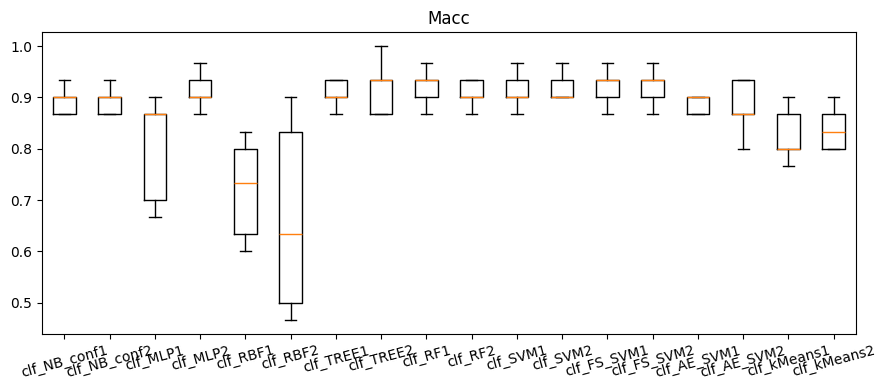

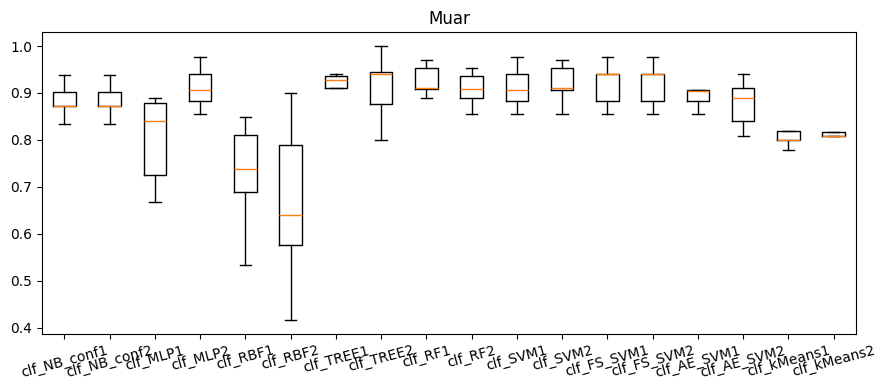

In [32]:
# -------------------------------
# Boxplots for each metric (except number of features)
for metric, data in stats_kfold.items():
    if metric != "Mnf":
        plt.figure(figsize=(9, 4))
        bpl = plt.boxplot(data.T, sym='')
        plt.title(metric)
        plt.xticks(range(1, len(classifiers)+1), classifiers, rotation=15)
        plt.tight_layout()
        plt.show()



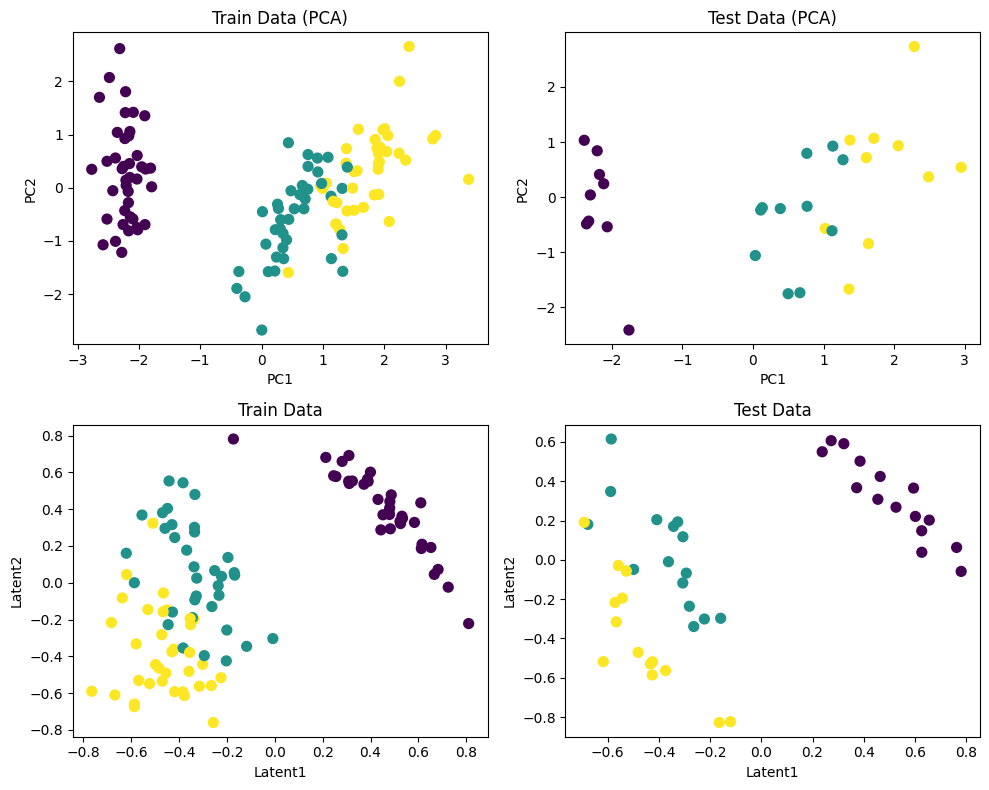

In [33]:
# -------------------------------
# Scatter plots using the last K-Fold's PCA data
# (X_train_fold_pca, X_test_fold_pca, y_train_fold, y_test_fold come from the last fold iteration)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
ax1.scatter(X_train_fold_pca[:,0], X_train_fold_pca[:,1], s=50, c=y_train_fold, marker="o")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("Train Data (PCA)")
ax2.scatter(X_test_fold_pca[:,0], X_test_fold_pca[:,1], s=50, c=y_test_fold, marker="o")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title("Test Data (PCA)")

# Plot AE_SVM latent representations on the last fold's data from the simple CV with PCA
# (using X_train_pca and X_test_pca from the simple CV with PCA split)
_ = clf_AE_SVM(X_train_pca, X_test_pca, y_train_p, y_test_p, plot=True, ax1=ax3, ax2=ax4)

plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import ttest_rel

print("Comparaciones Pareadas (Accuracy) entre Clasificadores:")
for i in range(len(classifiers)):
    for j in range(i+1, len(classifiers)):
        # Prueba t pareada entre los accuracies de los dos clasificadores en cada fold
        t_stat, p_val = ttest_rel(Macc[i], Macc[j])
        print(f"Entre {classifiers[i]} y {classifiers[j]}: t = {t_stat:.4f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print("  -> Diferencia SIGNIFICATIVA (α=0.05)")
        else:
            print("  -> Diferencia NO SIGNIFICATIVA")


Comparaciones Pareadas (Accuracy) entre Clasificadores:
Entre clf_NB_conf1 y clf_NB_conf2: t = nan, p = nan
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_MLP1: t = 2.0103, p = 0.1148
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_MLP2: t = -0.7385, p = 0.5012
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_RBF1: t = 3.3993, p = 0.0273
  -> Diferencia SIGNIFICATIVA (α=0.05)
Entre clf_NB_conf1 y clf_RBF2: t = 2.4442, p = 0.0709
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_TREE1: t = -0.6667, p = 0.5415
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_TREE2: t = -0.9300, p = 0.4050
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_RF1: t = -1.0887, p = 0.3375
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_RF2: t = -0.5898, p = 0.5870
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_SVM1: t = -0.7385, p = 0.5012
  -> Diferencia NO SIGNIFICATIVA
Entre clf_NB_conf1 y clf_SVM2: t = -1.3720, p = 0.2420
  -> Dife

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.datasets import load_iris
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.svm import SVC

# --- Definición del clasificador seleccionado (SVM) ---
def clf_SVM(X_train, X_test, y_train, y_test):
    # Usamos kernel polinomial, según el ejemplo previo
    clf = SVC(kernel='poly', degree=2, coef0=1, gamma='auto', random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    uar  = balanced_accuracy_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred, average='macro')
    nf   = X_train.shape[1]
    return acc, uar, rec, nf

# --- Carga y preparación de datos ---
iris = load_iris()
X, Y = shuffle(iris.data, iris.target, random_state=0)

# (Opcional) Para que los resultados sean comparables, podemos estandarizar todo el dataset:
scaler_global = StandardScaler()
X_std = scaler_global.fit_transform(X)

# --- 1. Repeated Stratified K-Fold ---
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
acc_rskf = []

n_splits = 10
test_size = 0.3
rsss = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=0)  # Adjust n_repeats

for train_index, test_index in rsss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    acc, _, _, _ = clf_SVM(X_train, X_test, y_train, y_test)
    acc_rskf.append(acc)

mean_acc_rskf = np.mean(acc_rskf)
std_acc_rskf = np.std(acc_rskf)
print("Repeated Stratified KFold - Mean Accuracy: {:.4f}, Std: {:.4f}".format(mean_acc_rskf, std_acc_rskf))

# --- 2. Repeated Stratified ShuffleSplit (particionado simple repetido) ---
from sklearn.model_selection import RepeatedStratifiedKFold # Updated import: using RepeatedStratifiedKFold
rsss = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0) # Updated usage: using RepeatedStratifiedKFold with splits and repeats for ShuffleSplit behaviour
acc_rsss = []

for train_idx, test_idx in rsss.split(X_std, Y):
    X_train_fold, X_test_fold = X_std[train_idx], X_std[test_idx]
    y_train_fold, y_test_fold = Y[train_idx], Y[test_idx]
    acc, _, _, _ = clf_SVM(X_train_fold, X_test_fold, y_train_fold, y_test_fold)
    acc_rsss.append(acc)

mean_acc_rsss = np.mean(acc_rsss)
std_acc_rsss = np.std(acc_rsss)
print("Repeated Stratified ShuffleSplit - Mean Accuracy: {:.4f}, Std: {:.4f}".format(mean_acc_rsss, std_acc_rsss))

# --- Comparación con resultados anteriores ---
# Supongamos que en los experimentos previos (por ejemplo, con KFold no estratificado o simple CV)
# se obtuvo un accuracy medio de 0.9533 (STD 0.0218) para SVM.
# Con estos métodos repetidos, comparamos:
print("\nComparación:")
print(f"Anterior: Mean ACC ~ 0.9533, STD ~ 0.0218")
print(f"Repeated Stratified KFold: Mean ACC = {mean_acc_rskf:.4f}, STD = {std_acc_rskf:.4f}")
print(f"Repeated Stratified ShuffleSplit: Mean ACC = {mean_acc_rsss:.4f}, STD = {std_acc_rsss:.4f}")


Repeated Stratified KFold - Mean Accuracy: 0.9667, Std: 0.0447
Repeated Stratified ShuffleSplit - Mean Accuracy: 0.9600, Std: 0.0533

Comparación:
Anterior: Mean ACC ~ 0.9533, STD ~ 0.0218
Repeated Stratified KFold: Mean ACC = 0.9667, STD = 0.0447
Repeated Stratified ShuffleSplit: Mean ACC = 0.9600, STD = 0.0533


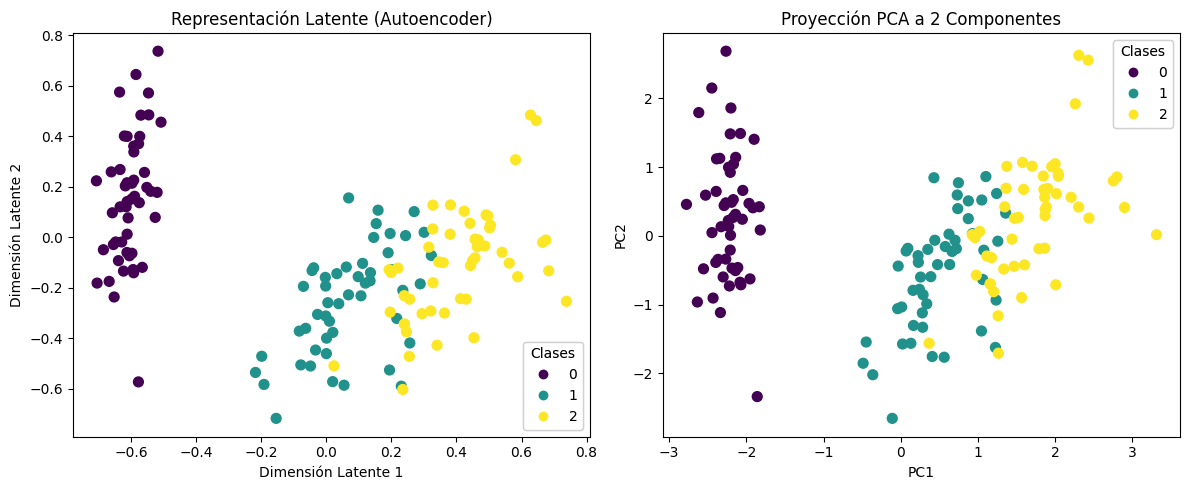

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

# Carga de datos
iris = load_iris()
X = iris.data
y = iris.target

# Estandarización de los datos
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# ---------------------------
# Autoencoder para obtener representación latente
# Arquitectura: Input -> 500 -> 300 -> 2 -> 300 -> 500 -> Input
n_input = X_std.shape[1]
AE = MLPRegressor(hidden_layer_sizes=(500, 300, 2, 300, 500),
                  activation='tanh',
                  solver='adam',
                  learning_rate_init=0.0001,
                  max_iter=500,
                  tol=1e-7,
                  verbose=False,
                  random_state=0)
AE.fit(X_std, X_std)

# Función "encoder" para extraer la representación latente (2 dimensiones)
def encoder(data, AE):
    data = np.asarray(data)
    # Primera capa oculta
    z1 = np.tanh(np.dot(data, AE.coefs_[0]) + AE.intercepts_[0])
    # Segunda capa oculta
    z2 = np.tanh(np.dot(z1, AE.coefs_[1]) + AE.intercepts_[1])
    # Capa latente de 2 neuronas
    latent = np.tanh(np.dot(z2, AE.coefs_[2]) + AE.intercepts_[2])
    return latent

latent_rep = encoder(X_std, AE)

# ---------------------------
# Proyección PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# ---------------------------
# Gráficas comparativas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Representación latente obtenida con el autoencoder
sc1 = ax1.scatter(latent_rep[:,0], latent_rep[:,1], c=y, cmap='viridis', s=50)
ax1.set_title("Representación Latente (Autoencoder)")
ax1.set_xlabel("Dimensión Latente 1")
ax1.set_ylabel("Dimensión Latente 2")
leg1 = ax1.legend(*sc1.legend_elements(), title="Clases")
ax1.add_artist(leg1)

# Proyección en componentes principales (PCA)
sc2 = ax2.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=50)
ax2.set_title("Proyección PCA a 2 Componentes")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
leg2 = ax2.legend(*sc2.legend_elements(), title="Clases")
ax2.add_artist(leg2)

plt.tight_layout()
plt.show()


Se entrena un MLPRegressor con una arquitectura simétrica que incluye una capa intermedia de 2 neuronas (bottleneck) que actúa como la representación latente. Luego se define una función `encoder` que realiza una pasada hacia adelante hasta obtener la salida de la capa latente. Y tambien se aplica PCA sobre los datos estandarizados para obtener dos componentes principales, lo que corresponde a la proyección en R² mostrada en la Figura 3.

### **Ejercicio 3: dataset "Leukemia"**

In [37]:
# Carga de datos y preprocesamiento
# Leukemia

data_train = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_train.csv', header=None)
data_test  = pd.read_csv('http://tsam-fich.wikidot.com/local--files/apuntes/leukemia_test.csv', header=None)

# separo patrones en X y etiquetas en Y para train y test
X_train = np.array(data_train)[:,:-1]           # patrones train
y_train = np.ravel(np.array(data_train)[:,-1:]) # etiquetas train
X_test = np.array(data_test)[:,:-1]             # patrones test
y_test = np.ravel(np.array(data_test)[:,-1:])   # etiquetas test

# Estandarización
scaler = StandardScaler()
# Ajuste sobre de train
scaler.fit(X_train)
# transformación de datos train y test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# defino lista de clasificadores
classifiers = ["clf_NB_conf1","clf_NB_conf2","clf_MLP1","clf_MLP2","clf_RBF1","clf_RBF2","clf_TREE1","clf_TREE2","clf_RF1","clf_RF2","clf_SVM1","clf_SVM2","clf_FS_SVM1","clf_FS_SVM2","clf_AE_SVM1","clf_AE_SVM2","clf_kMeans1","clf_kMeans2"]


# defino lista de clasificadores
#classifiers = ["clf_NB","clf_MLP","clf_RBF","clf_TREE","clf_RF","clf_SVM","clf_kMeans"]

**Evaluación de desempeño de los clasificadores empleando las 7129 características**

In [38]:
vacc = []
vuar = []
vrec = []
vnf  = []

start_time = time.time()
for clf in range(0,len(classifiers)):
    acc, uar, rec, nf = locals()[classifiers[clf]](X_train, X_test, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vrec.append(rec)
    vnf.append(nf)

elapsed_time = time.time() - start_time

print(':::          Complete Feature Set             :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time)

:::          Complete Feature Set             :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf1   │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf2   │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     MLP1     │  0.8824  │ 0.8679 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     MLP2     │  0.8824  │ 0.8786 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     RBF1     │  0.5882  │ 0.5000 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│     RBF2     │  0.5882  │ 0.5000 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│    TREE1     │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤
│    TREE2     │  0.9118  │ 0.9143 │    7129    │
├──────────────┼──────────┼────────┼────────────┤


**Selección de características mediante método de ranking basado en ANOVA F-value**


In [39]:
# defino el método de ranking con criterio de ANOVA F (f_classif)
FS = SelectKBest(f_classif, k=20)    # definir cuántas características se desean seleccionar

start_time = time.time()
# realizo la selección en base a datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# aplico la selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)

elapsed_time_2 = time.time() - start_time

print(':::   K-Best Ranking based on ANOVA F-value   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf],  vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

:::   K-Best Ranking based on ANOVA F-value   :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf1   │  0.9412  │ 0.9393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf2   │  0.9412  │ 0.9393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP1     │  0.8529  │ 0.8321 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP2     │  0.9412  │ 0.9286 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF1     │  0.7941  │ 0.8143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF2     │  0.8824  │ 0.8571 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE1     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE2     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤


**Selección de características mediante el método Eliminación Recursiva (RFE) empleando SVM lineal**


In [40]:
# Defino método de evaluación
estimator = LinearSVC(random_state=0, tol=1e-5)
# Defino método de búsqueda
FS = RFE(estimator, n_features_to_select=20,       # definir cuántas características se desean seleccionar
         step=1)                                   # definir cuántas características se eliminan en cada iteración

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::             RFE - linear SVM              :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

:::             RFE - linear SVM              :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf1   │  0.8824  │ 0.9000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf2   │  0.8824  │ 0.9000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP1     │  0.9118  │ 0.9036 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP2     │  0.9412  │ 0.9286 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF1     │  0.5882  │ 0.5000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF2     │  0.5882  │ 0.5000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE1     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE2     │  0.9118  │ 0.9143 │     20     │
├──────────────┼──────────┼────────┼────────────┤


**Selección de características mediante el método Relief**


In [41]:
# Selección de características mediante Relief

FS = relief.Relief(n_features=20) # definir cuántas características se desean seleccionar

start_time = time.time()
# Selección de características sobre datos de train
FS = FS.fit(X_train, y_train)
elapsed_time = time.time() - start_time
# Aplico selección en train y test
X_train_new = FS.transform(X_train)
X_test_new  = FS.transform(X_test)

vacc = []
vuar = []
vnf  = []

start_time = time.time()
# Evaluación de clasificadores con las características seleccionadas
for clf in range(0,len(classifiers)):
    acc, uar, _, nf = locals()[classifiers[clf]](X_train_new, X_test_new, y_train, y_test)
    vacc.append(acc)
    vuar.append(uar)
    vnf.append(nf)
elapsed_time_2 = time.time() - start_time

print(':::                  Relief                   :::')
table = [["Clasificador","Accuracy","UAR", "# Features"]]
for clf in range(0,len(classifiers)):
    table.append([classifiers[clf][4:], '%.4f' % vacc[clf], '%.4f' % vuar[clf], vnf[clf] ])
print(tabulate(table, tablefmt="fancy_grid", stralign="center"))
print("Tiempo Selección de Características: ", '%.4f' % elapsed_time)
print("Tiempo Total Clasificadores: ", '%.4f' % elapsed_time_2)

:::                  Relief                   :::
╒══════════════╤══════════╤════════╤════════════╕
│ Clasificador │ Accuracy │  UAR   │ # Features │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf1   │  0.8235  │ 0.8393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│   NB_conf2   │  0.8235  │ 0.8393 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP1     │  0.7941  │ 0.8036 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     MLP2     │  0.7941  │ 0.7821 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF1     │  0.7353  │ 0.7536 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│     RBF2     │  0.5882  │ 0.5000 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE1     │  0.7059  │ 0.6536 │     20     │
├──────────────┼──────────┼────────┼────────────┤
│    TREE2     │  0.7059  │ 0.6536 │     20     │
├──────────────┼──────────┼────────┼────────────┤
